In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../ipsim'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ipsim import *

import numpy as np
import random as rnd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import export_text

from sklearn.model_selection import train_test_split

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import matplotlib

from copy import deepcopy

In [2]:
class ECSRTTest:
    Ea  = 72750     # activation energy J/gmol
    R   = 8.314     # gas constant J/gmol/K
    k0  = 7.2e10    # Arrhenius rate constant 1/min
    dHr = -5.0e4    # Enthalpy of reaction [J/mol]
    rho = 1000.0    # Density [g/L]
    Cp  = 0.239     # Heat capacity [J/g/K]
    UA  = 5.0e4     # Heat transfer [J/min/K]
    
    V   = 100.0     # Volume [L]
    q   = 100.0     # Flowrate [L/min]
    cAi = 1.0       # Inlet feed concentration [mol/L]
    Ti  = 350.0     # Inlet feed temperature [K]
    Tc  = 305.0     # Coolant temperature [K]

    cA0 = 0.5;      # Initial concentration [mol/L]
    T0  = 350.0;    # Initial temperature [K]
    
    def k(T):
        return ECSRTTest.k0*np.exp(-ECSRTTest.Ea/ECSRTTest.R/T)


In [3]:
class ExothermicContinuousStirredTankReactor0(ProcessNode):
    def __init__(self, name, *, cA0 = ECSRTTest.cA0, T0 = ECSRTTest.T0, V = ECSRTTest.V
                , dHr = ECSRTTest.dHr, rho = ECSRTTest.rho, Cp=ECSRTTest.Cp,UA = ECSRTTest.UA):
        super().__init__(name)
        self._cA = deepcopy(cA0)
        self._T = deepcopy(T0)
        self._cB = 0
        self._V = V
        self._dHr = dHr
        self._rho=rho
        self._Cp = Cp
        self._UA = UA
        self.create_input("q")
        self.create_input("cAi")
        self.create_input("Ti")
        self.create_input("Tc")
        self.create_output("cA")
        self.create_output("T")
        self.create_output("cB")
        self._calltimes = 0
    
    def __call__(self, t, y):
        i = self.inputs()
        q   = i["q"]()
        cAf = i["cAi"]()
        Tf  = i["Ti"]()
        Tc  = i["Tc"]()

        cA, T, cB = y
       
        qV    = q/self._V
        kCa = ECSRTTest.k(T)*cA
        dHpC  = -self._dHr/(self._rho*self._Cp)
        UAVpC = self._UA/(self._V*self._rho*self._Cp)

        dcAdt = qV*(cAf - cA) - kCa
        dTdt  = qV*(Tf - T) + dHpC*kCa + UAVpC*(Tc-T)
        dBdt  = qV*(0 - cB) + kCa

        return [dcAdt, dTdt, dBdt]
        
    def evaluate(self):
        self._calltimes = self._calltimes+1
        
        i = self.inputs()
        q   = i["q"]()
        cAf = i["cAi"]()
        Tf  = i["Ti"]()
        Tc  = i["Tc"]()
        cA  = self._cA
        T   = self._T
        cB  = self._cB
        
        dt = self._model.dt()

        t_eval = np.linspace(0, dt, 10)
        soln = solve_ivp(self, [min(t_eval), max(t_eval)], [cA, T, cB], t_eval=t_eval)
        
        cA = soln.y[0, :][-1]
        T  = soln.y[1, :][-1]
        cB = soln.y[2, :][-1]
        
        self._cA = cA
        self._T = T
        self._cB = cB
        
        self.set_result("cA",cA)
        self.set_result("cB",cB)
        self.set_result("T",T)


In [4]:
class NoisySensor(Sensor):
    def __init__(self, name, input_name, *, dev_prob = 0, dev_amp = 0):
        super().__init__(name, input_name)
        self._dev_prob = dev_prob
        self._dev_amp = dev_amp
        self._input_name = input_name

    def evaluate(self):
        value = self.inputs()[self._input_name]()
        if (self._dev_prob > 0) and (self._dev_amp > 0):
            prob = rnd.uniform(0,1)
            if prob < self._dev_prob:
                amp = rnd.uniform(-self._dev_amp, self._dev_amp)
                value = value + amp
                value = value if value > 0 else 0 
                
        self.set_result(self._input_name, value)

    def change_value(self, name, value):
        if name == "dev_prob":
            self._dev_prob = value
        if name == "dev_amp":
            self._dev_amp = value

In [5]:
def prepare_model(dt = 10.0/2000):    
    process_model = ProcessModel("test",dt=dt)
    process_model.add_node(ProcessInputNode("InletFeed"
                                         , {"Flowrate":100,"Concentration":1,"Temperature":350}))
    process_model.add_node(ProcessInputNode("Coolant"
                                          , {"Temperature":290}))
    process_model.add_node(ExothermicContinuousStirredTankReactor0("ECSTR"))
    process_model.bond_nodes("ECSTR","q","InletFeed","Flowrate")
    process_model.bond_nodes("ECSTR","cAi","InletFeed","Concentration")
    process_model.bond_nodes("ECSTR","Ti","InletFeed","Temperature")
    process_model.bond_nodes("ECSTR","Tc","Coolant","Temperature")
    
    process_model.add_node(NoisySensor("SensorA","cA"))
    process_model.add_node(NoisySensor("SensorB","cB"))
    process_model.add_node(NoisySensor("SensorT","T"))
    
    process_model.bond_nodes("SensorA","cA", "ECSTR", "cA")
    process_model.bond_nodes("SensorB","cB", "ECSTR", "cB")
    process_model.bond_nodes("SensorT","T", "ECSTR", "T")
        
    return process_model

In [6]:
def run_model_clean(process_model, iterations): 
    parameters_metadata = (
          {"parameter":"cA", "range":(0,1), "units": "mol/L", "title":"Concentration of A"}
        , {"parameter":"cB", "range":(0,1), "units": "mol/L", "title":"Concentration of B"}
        , {"parameter":"T", "range":(300,500),"units": "K", "title":"Temperature" }
    )
    x = np.empty((iterations,len(parameters_metadata)))
    for _ in range(iterations):
        state = process_model.next_state(("ECSTR",))
        data =  []
        for metadata in parameters_metadata:
             data.append(state['ECSTR'][metadata["parameter"]])

        x[_] =  data

    return x, parameters_metadata

In [7]:
def show_data(x, metadata, dt, title = "", *, cols=3):
    fig = plt.figure(figsize=(6,6),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                plt.plot([i/int(1/dt) for i in range(len(x))] ,x[:,index])
                plt.title(metadata[index]["title"])
    
    plt.tight_layout()
    plt.show()

In [8]:
def show_unined_data(xa, metadata, dt, legends = (), title = "", *, cols=3):
    fig = plt.figure(figsize=(12,3),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    #fmts = ("-k", "--r",  "-.g", ":k", ":m", "-b")
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                ax = plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                for xi in range(len(xa)):
                    x = xa[xi]
                    #fmt = fmts[xi]
                    plt.plot([i/int(1/dt) for i in range(len(x))] ,x[:,index])#, fmt)
                plt.xlabel('min')
                plt.ylabel(metadata[index]["units"])
                plt.title(metadata[index]["title"])
    
    plt.tight_layout()
    fig.legend(legends,loc='outside right upper')
    plt.tight_layout()
    plt.show()

In [9]:
def run_0():
    iterations = 2000
    target_time = 10
    dt = target_time/iterations
    process_model = prepare_model(dt)
    process_model.nodes()["Coolant"].change_value("Temperature",305)
    x, metadata = run_model_clean(process_model,iterations)
    show_data(x, metadata, dt)

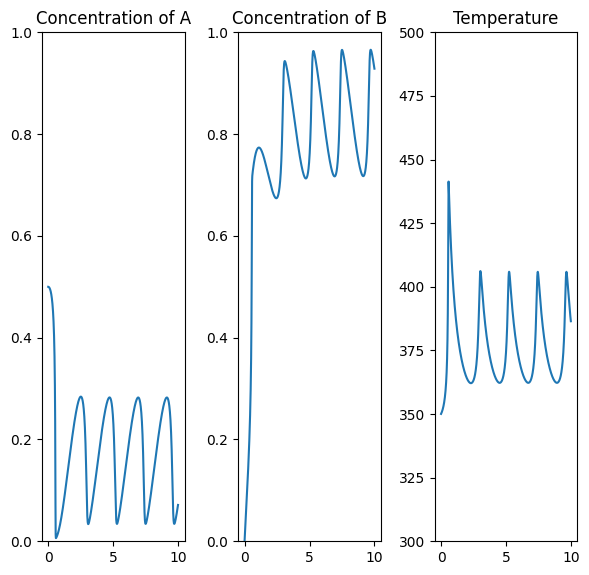

In [15]:
run_0()

In [10]:
def run_1():
    iterations = 1000
    target_time = 10
    dt = target_time/iterations

    xa = []
    ma = []
    la = []
    for Tc in range(290,310,1):
        process_model = prepare_model(dt)
        process_model.nodes()["Coolant"].change_value("Temperature",Tc)
        x, metadata = run_model_clean(process_model,iterations)
        xa.append(x)
        ma.append(metadata)
        la.append(f"Coolant T {Tc}")
        
    show_unined_data(xa, metadata, dt, la)

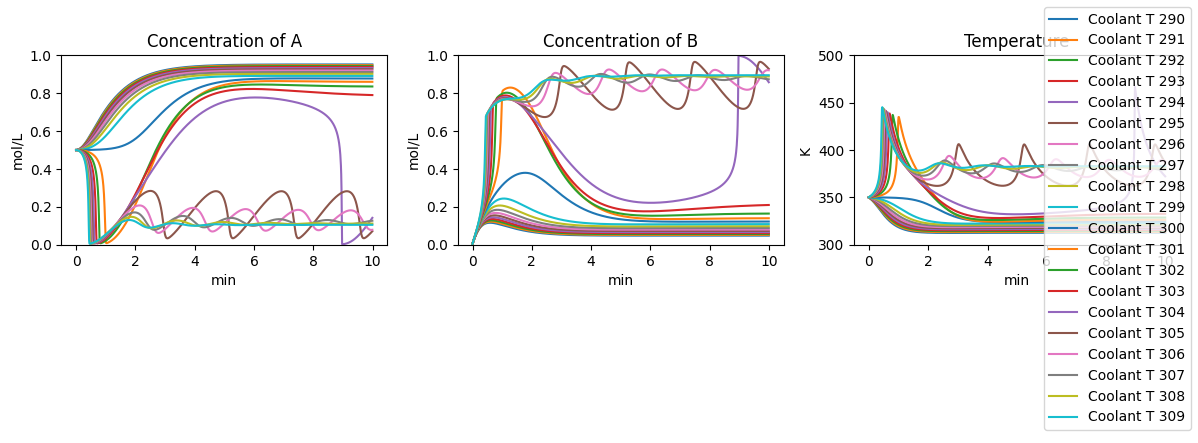

In [11]:
run_1()

In [12]:
def run_model_clean_ex(process_model, iterations): 
    observed_nodes = ("SensorA","SensorB","SensorT",)

    parameters_metadata = (
          {"parameter":"cA"
           , "range":(0,1)
           , "units": ""
           , "title":"Concentration of A"
           , "sensor_node": "SensorA"}
        , {"parameter":"cB"
           , "range":(0,1)
           , "units": ""
           , "title":"Concentration of B"
           , "sensor_node": "SensorB"}
        , {  "parameter":"T"
           , "range":(300,600)
           , "units": "K"
           , "title":"Temperature"
           , "sensor_node": "SensorT" }
    )

    x = np.empty((iterations,len(parameters_metadata)))
    for _ in range(iterations):
        state = process_model.next_state(observed_nodes)
        data =  []
        for metadata in parameters_metadata:
             data.append(state[metadata['sensor_node']][metadata["parameter"]])

        x[_] =  data

    return x, parameters_metadata

In [13]:
def run_oscilation_with_noise():
    dt = 0.1
    iterations = 200

    process_model = prepare_model(dt)
    process_model.nodes()["Coolant"].change_value("Temperature",305)

    sensorA =  process_model.nodes()["SensorA"]
    sensorB =  process_model.nodes()["SensorB"]
    sensorT =  process_model.nodes()["SensorT"]
    
    sensorA.change_value("dev_prob", 1)
    sensorA.change_value("dev_amp", 0.05)

    sensorB.change_value("dev_prob", 1)
    sensorB.change_value("dev_amp", 0.05)
    
    sensorT.change_value("dev_prob", 1)
    sensorT.change_value("dev_amp", 10) 

    x, metadata = run_model_clean_ex(process_model,iterations)
    show_data(x, metadata, dt) 

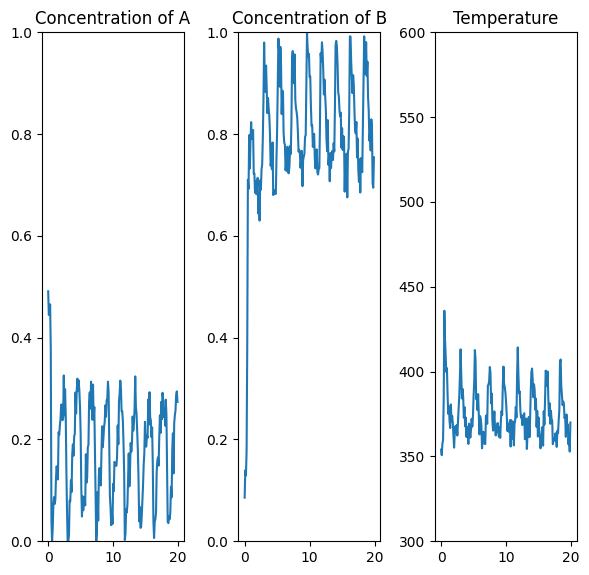

In [14]:
run_oscilation_with_noise()

In [16]:
def run_model_steps(process_model, Tcs, iterations_per_step): 
    parameters_metadata = (
          {"parameter":"cA", "range":(0,1), "units": "", "title":"Concentration of A"}
        , {"parameter":"cB", "range":(0,1), "units": "", "title":"Concentration of B"}
        , {"parameter":"T", "range":(300,600),"units": "K", "title":"Temperature" }
    )

    iterations = int(len(Tcs)*iterations_per_step)
    x = np.empty((iterations,len(parameters_metadata)))
    y = np.empty((iterations,1),dtype=np.dtype('B'))

    Tci = -1
    Tc  = 0
    for _ in range(iterations):
        if _ % iterations_per_step == 0:
            Tci = 0 if Tci == -1 else Tci + 1
            Tc = Tcs[Tci]                 
            process_model.nodes()["Coolant"].change_value("Temperature", Tc)
        state = process_model.next_state(("ECSTR",))
        data =  []
        for metadata in parameters_metadata:
             data.append(state['ECSTR'][metadata["parameter"]])

        x[_] =  data
        y[_] = 0 if (Tc < 304 or Tc > 307) else 1

    return x, parameters_metadata, y

In [17]:
def run_model_steps_ex(process_model, Tcs, iterations_per_step): 
    observed_nodes = ("SensorA","SensorB","SensorT",)

    parameters_metadata = (
          {"parameter":"cA"
           , "range":(0,1)
           , "units": ""
           , "title":"Concentration of A"
           , "sensor_node": "SensorA"}
        , {"parameter":"cB"
           , "range":(0,1)
           , "units": ""
           , "title":"Concentration of B"
           , "sensor_node": "SensorB"}
        , {  "parameter":"T"
           , "range":(300,600)
           , "units": "K"
           , "title":"Temperature"
           , "sensor_node": "SensorT" }
    )

    iterations = int(len(Tcs)*iterations_per_step)
    x = np.empty((iterations,len(parameters_metadata)))
    y = np.empty((iterations,1),dtype=np.dtype('B'))

    Tci = -1
    Tc  = 0
    for _ in range(iterations):
        if _ % iterations_per_step == 0:
            Tci = 0 if Tci == -1 else Tci + 1
            Tc = Tcs[Tci]                 
            process_model.nodes()["Coolant"].change_value("Temperature", Tc)
        state = process_model.next_state(observed_nodes)
        data =  []
        for metadata in parameters_metadata:
             data.append(state[metadata['sensor_node']][metadata["parameter"]])

        x[_] =  data
        y[_] = 0 if (Tc < 304 or Tc > 307) else 1

    return x, parameters_metadata, y

In [18]:
def train_logistic(x,y):
    model = LogisticRegression()
    model.fit(x, y.ravel())
    return model

def train_random_forest(x,y):
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(x, y.ravel())
    return model

def train_gradient_boostins(x,y):
    model = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=1, random_state=0)
    model.fit(x, y.ravel())
    return model

def train_ada_boostins(x,y):
    model = AdaBoostClassifier(n_estimators=500, algorithm="SAMME", random_state=0)
    model.fit(x, y.ravel())
    return model

In [19]:
def show_model_statistics(y, y_pred, model_name):        
    f_metrics = {"Accuracy":accuracy_score
                ,"Precision":precision_score
                ,"Recall":recall_score
                ,"F1" : f1_score
                ,"Cohens kappa": cohen_kappa_score
                ,"ROC AUC": roc_auc_score
                ,"Confusion matrix": confusion_matrix}
    print(f"{model_name}:")
    for metric in f_metrics:
        try:
            print(metric, f_metrics[metric](y, y_pred))
        except Exception as e:
            print(f"Metiric {metric}: {e}")

In [22]:
def run_show_operation_modes():
    iterations = 1000
    target_time = 10
    dt = target_time/iterations

    xa = []
    ma = []
    la = []
    for Tc in [300,304,307,311]:
        process_model = prepare_model(dt)
        process_model.nodes()["Coolant"].change_value("Temperature",Tc)
        x, metadata = run_model_clean(process_model,iterations)
        xa.append(x)
        ma.append(metadata)
        la.append(f"Tc={Tc}")
        
    show_unined_data(xa, metadata, dt, la)

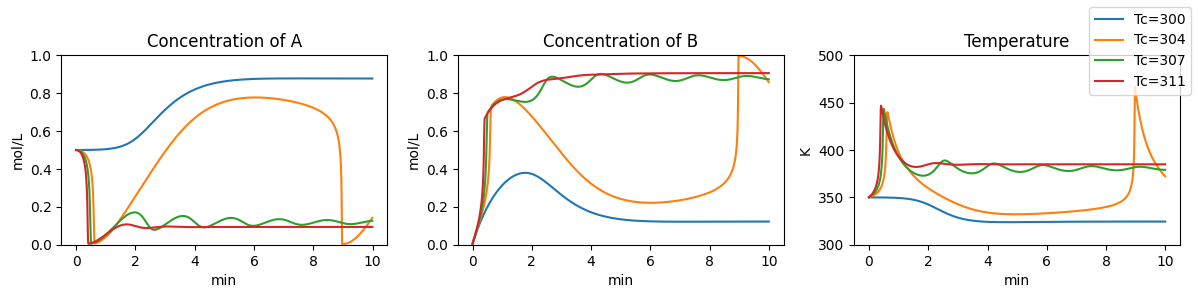

In [23]:
run_show_operation_modes()

In [24]:
def run_train_model_with_noise():
    dt = 0.1
    process_model = prepare_model(dt)
    
    sensorA =  process_model.nodes()["SensorA"]
    sensorB =  process_model.nodes()["SensorB"]
    sensorT =  process_model.nodes()["SensorT"]

    sensorA.change_value("dev_prob", 1)
    sensorA.change_value("dev_amp", 0.05)

    sensorB.change_value("dev_prob", 1)
    sensorB.change_value("dev_amp", 0.05)
    
    sensorT.change_value("dev_prob", 1)
    sensorT.change_value("dev_amp", 10) 

    observed_nodes = ("SensorA","SensorB","SensorT",)
    for _ in range(100): # skip first iteration to reach steady-state 
        process_model.next_state(observed_nodes)

    x, metadata, y = run_model_steps_ex(process_model,[300, 303, 304, 305, 306, 308, 310], 200)
    count_true = 0
    for yi in y:
        if yi == 0:
            count_true += 1
    print(f"normal class: {count_true} faults: {len(y)-count_true} total: {len(y)}")

    models = {#"ff_nn": train_ff_nn
              "logistic":train_logistic
             ,"random_forest":train_random_forest
             ,"gradient_boostins":train_gradient_boostins
             ,"ada_boostins": train_ada_boostins
             # ,"bagging":train_bagging
             }
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

    trained_models = {}
    for title, func in models.items():
        ml_model = func(x_train,y_train)
        y_pred   = ml_model.predict(x_test)
        show_model_statistics(y_test,y_pred, title)
        trained_models[title] = ml_model

    return trained_models

In [26]:
def run_test_trained_models_with_noise(Tc, trained_models):
    dt = 0.1
    process_model = prepare_model(dt)
    process_model.nodes()["Coolant"].change_value("Temperature", Tc)

    sensorA =  process_model.nodes()["SensorA"]
    sensorB =  process_model.nodes()["SensorB"]
    sensorT =  process_model.nodes()["SensorT"]

    sensorA.change_value("dev_prob", 1)
    sensorA.change_value("dev_amp", 0.05)

    sensorB.change_value("dev_prob", 1)
    sensorB.change_value("dev_amp", 0.05)
    
    sensorT.change_value("dev_prob", 1)
    sensorT.change_value("dev_amp", 10) 

    observed_nodes = ("SensorA","SensorB","SensorT",)
    for _ in range(200): # skip first iteration to reach steady-state 
        process_model.next_state(observed_nodes)

    faults_detected = {}
    for title, model in trained_models.items():
        faults_detected[title] = 0

    for _ in range(100):
        state = process_model.next_state(observed_nodes)
        data = (state['SensorA']['cA'], state['SensorB']['cB'], state['SensorT']['T'],)
        x = np.empty((1,3))
        x[0] = data
        for title, model in trained_models.items():
            y_pred = model.predict(x)
            if y_pred[0] > 0.5:
                faults_detected[title] += 1
                
    return faults_detected

In [28]:
def run_train_test_show_results():
    trained_models = run_train_model_with_noise()
    r = export_text(trained_models["random_forest"].estimators_[0])
    print(r)

    TC_START = 300
    TC_STEP  = 0.5
    TC_STEPS = 30

    model_results = [] 
    for _ in range(TC_STEPS):
        value = TC_START + _*TC_STEP
        print(f"-----{_}-----")
        model_results.append(run_test_trained_models_with_noise(value, trained_models))
    
    i = 0
    models_names = ["Logistic Regression"
                   ,"Random Forest"
                   ,"Gradient Boostins"
                   ,"Ada Boostins",]
    
    x = np.zeros((len(model_results), len(models_names)))
    for mr in model_results:
        x[i] = ( mr["logistic"]
               , mr["random_forest"]
               , mr["gradient_boostins"]
               , mr["ada_boostins"], )
        i = i + 1

    SMALL_SIZE = 18
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 22

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig = plt.figure(figsize=(12,3),)
    for i in range(len(models_names)):
        plt.plot([TC_START + _*TC_STEP for _ in range(TC_STEPS)], x[:,i])

    tfx = []
    tfy = []
    for _ in range(TC_STEPS):
        value = TC_START + _*TC_STEP
        tfx.append(value)
        tfy.append(0 if (value < 304 or value > 307) else 100)
    plt.plot(tfx, tfy, "--k")
    models_names.append("Truth Fault")
 
    plt.xlabel("Coolant temperature [K]")
    plt.ylabel("Percent of values marked as fault")
    fig.legend(models_names,loc='outside right upper')
    plt.show()

normal class: 800 faults: 600 total: 1400
logistic:
Accuracy 0.45714285714285713
Precision 0.36153846153846153
Recall 0.3051948051948052
F1 0.33098591549295775
Cohens kappa -0.12028301886792447
ROC AUC 0.44086270871985156
Confusion matrix [[226 166]
 [214  94]]
random_forest:
Accuracy 0.78
Precision 0.826271186440678
Recall 0.6331168831168831
F1 0.7169117647058822
Cohens kappa 0.5421027592768792
ROC AUC 0.7642625231910946
Confusion matrix [[351  41]
 [113 195]]
gradient_boostins:
Accuracy 0.8371428571428572
Precision 0.8464285714285714
Recall 0.7694805194805194
F1 0.8061224489795918
Cohens kappa 0.6662763466042154
ROC AUC 0.8298933209647494
Confusion matrix [[349  43]
 [ 71 237]]
ada_boostins:
Accuracy 0.8514285714285714
Precision 0.9015748031496063
Recall 0.7435064935064936
F1 0.8149466192170818
Cohens kappa 0.6927440321437013
ROC AUC 0.8398654916512058
Confusion matrix [[367  25]
 [ 79 229]]
|--- feature_2 <= 329.68
|   |--- feature_0 <= 0.80
|   |   |--- class: 0.0
|   |--- feature_

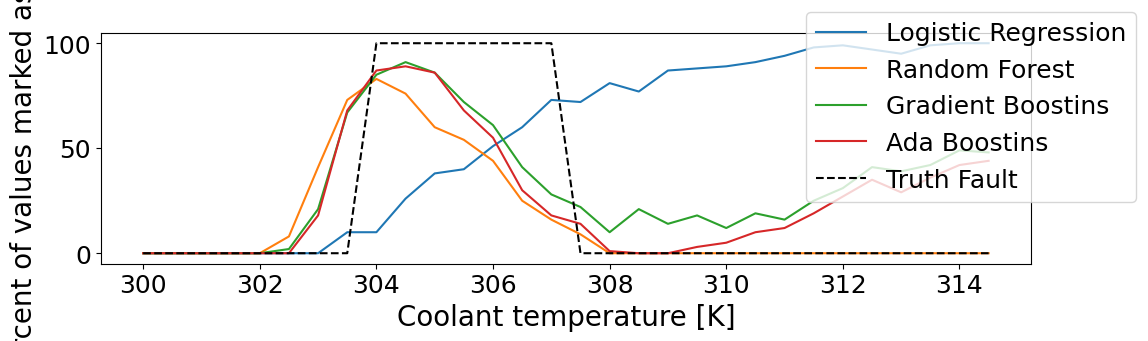

In [29]:
run_train_test_show_results()